<p><font size="6"><b>Projet 4 - Openclassrooms. Data Science </b></font></p>


<p><font size="5"><b>Anticipez les besoins en consommation électrique de bâtiments </b></font></p>

<p><font size="4"><b>*Partie 2: Modélisation </b></font></p>


Source de données : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv
        
*© 2021, Ilham Noumir  (mailto:noumir.ilham@gmail.com)

## <div class="alert alert-info"> 0. Importation des bibliothèques et chargement des données : </div> 

#### Importation des bibliothèques : 

In [13]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt 
from sklearn import metrics
import math
import timeit

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV , ShuffleSplit ,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from scipy import stats

from xgboost import XGBRegressor
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_colwidth', -1)
plt.rcParams.update({'font.size':15})



plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=30) 

#### Chargement des données : 

In [14]:
data= pd.read_csv('data_Cleaned.csv')

In [15]:
data.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3.162000e+03,3162.000000,3.162000e+03,3.162000e+03,1634.000000,676.00000,2115.000000,3.162000e+03,3162.000000,3162.000000,3162.000000
mean,15882.071157,2015.514231,4.364643,1.114801,4.152435,1.162019e+05,13374.462366,1.028274e+05,9.573655e+04,35966.839227,14068.52130,64.870449,8.015155e+06,178.084213,1.492903,53.854206
std,13294.857641,0.499876,2.198369,2.261693,6.659394,2.549131e+05,44063.634812,2.375794e+05,2.294200e+05,66820.340975,32917.49635,28.075436,2.097926e+07,676.400439,2.171687,32.664098
min,1.000000,2015.000000,1.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.00000,1.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,580.250000,2015.000000,2.000000,1.000000,1.000000,2.941700e+04,0.000000,2.849200e+04,2.550525e+04,5400.000000,2598.00000,48.000000,1.356990e+06,20.292500,0.280000,27.000000
50%,21116.000000,2016.000000,4.000000,1.000000,2.000000,4.898850e+04,0.000000,4.703750e+04,4.312200e+04,12353.000000,6000.00000,72.000000,2.707758e+06,49.580000,0.800000,50.000000
75%,24532.000000,2016.000000,7.000000,1.000000,4.000000,1.041725e+05,0.000000,9.447000e+04,9.034500e+04,30949.750000,12369.25000,88.000000,7.132133e+06,138.807500,1.790000,86.000000
max,50226.000000,2016.000000,7.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.00000,100.000000,4.716139e+08,16870.980000,34.090000,116.000000


In [16]:
data.shape

(3162, 27)

In [18]:
data= data[~(data['SiteEnergyUseWN(kBtu)']==0)]
data= data[~(data['TotalGHGEmissions']==0)]

## <div class="alert alert-info"> 1. Feature engineering  : </div> 

#### Sélection des variables : 

In [6]:
data_model= data[['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType', 'Neighborhood',
'DefaultData',   'ComplianceStatus' ,
'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
'PropertyGFAParking', 'PropertyGFABuilding(s)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)','BuildingAge']]

In [7]:
numerical_columns = data_model.select_dtypes(['int64', 'float64'])
categorical_columns= data_model.select_dtypes(exclude=['int64', 'float64'])
print('Les varaibles quantitatives avec les cibles:\n')
for col in numerical_columns: 
    print(col)
print('-'*100)
print('Les varaibles qualitatives:\n ')
for col in categorical_columns.columns: 
    print(col, data[col].nunique())

Les varaibles quantitatives avec les cibles:

NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
TotalGHGEmissions
SiteEnergyUseWN(kBtu)
BuildingAge
----------------------------------------------------------------------------------------------------
Les varaibles qualitatives:
 
BuildingType 5
PrimaryPropertyType 18
LargestPropertyUseType 27
Neighborhood 13
DefaultData 2
ComplianceStatus 2


#### Séparation des outputs et inputs :

In [8]:
y_columns = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)']
y= data_model['SiteEnergyUseWN(kBtu)']
X = data_model.drop(y_columns, axis=1)

In [9]:
print(X.shape)
print(y.shape)

(3140, 12)
(3140,)


####  Visualisation des variables quantitatives et qualitatives de la variable X 

In [10]:
numeric_columns = X.select_dtypes(['int64','float64']).columns
categoric_columns= X.select_dtypes(exclude=['int64','float64']).columns
print(numeric_columns)
print(categoric_columns)


Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'BuildingAge'],
      dtype='object')
Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'Neighborhood', 'DefaultData', 'ComplianceStatus'],
      dtype='object')


Dans un premier temps j'ai fait le choix de réaliser quelques modèles sans transformation des variables cibles pour savoir les scores aprés et avant.

#### Pipeline 

In [11]:
preprocessor = make_column_transformer((RobustScaler(),numeric_columns),(OneHotEncoder(handle_unknown = 'ignore'),categoric_columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2512, 12) (2512,)
(628, 12) (628,)


## <div class="alert alert-info"> 2. Modélisation  : </div> 

####  Régression linéaire simple :  Variable cible -> SiteEnergyUse

In [78]:
model = make_pipeline(preprocessor,LinearRegression())
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("score d'entrainement = ",model.score(X_train,y_train))
print("le coefficient de détrmination est :" ,r2_score(y_test, model.predict(X_test)))
print('MAE:', metrics.mean_absolute_error(y_test,predictions))
print('MSE:', metrics.mean_squared_error(y_test,predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

score d'entrainement =  0.7337547775762285
le coefficient de détrmination est : 0.2641975820201792
MAE: 4526233.024799622
MSE: 354922596090578.06
RMSE: 18839389.482957724


#####  Pour les deux cibles : SiteEnergyUse et TotalGHGEmissions

In [79]:
y_columns = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)']
y= data_model['SiteEnergyUseWN(kBtu)']
X = data_model.drop(y_columns, axis=1)
for yi in y_columns:
    print('-'*100)
    print("Régression Linéaire simple pour la variable :", yi)
    print('\n')
    y= data_model[yi]
    preprocessor = make_column_transformer((RobustScaler(),numeric_columns),(OneHotEncoder(handle_unknown = 'ignore'),categoric_columns))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = make_pipeline(preprocessor,LinearRegression())
    model.fit(X_train, y_train)
    print("score d'entrainement = ",model.score(X_train,y_train))
    print("le coefficient de détrmination est :" ,r2_score(y_test, model.predict(X_test)))
    print('MAE:', metrics.mean_absolute_error(y_test,predictions))
    print('MSE:', metrics.mean_squared_error(y_test,predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

----------------------------------------------------------------------------------------------------
Régression Linéaire simple pour la variable : TotalGHGEmissions


score d'entrainement =  0.4607537334182311
le coefficient de détrmination est : 0.7195880543439777
MAE: 7726647.073037743
MSE: 227071839444417.97
RMSE: 15068903.060422745
----------------------------------------------------------------------------------------------------
Régression Linéaire simple pour la variable : SiteEnergyUseWN(kBtu)


score d'entrainement =  0.6656746334549519
le coefficient de détrmination est : 0.3685122869062929
MAE: 10600986.356735898
MSE: 437227110131221.4
RMSE: 20909976.33024058


Ici jai choisi une autre façon de procèder autre que la pipeline . c'est à dire J'ai effectué la transformation sur chacune des deux parties de X : la partie numérique et la partie qualitative aprés je les stocker séparément sur deux Dataframes aprés je les concaténer dansuns seule Dataframe.

In [80]:
print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape)


for yi in y_columns: 
    print('-'*100)
    print("Régression Linéaire simple pour la variable :", yi)
    print('\n')
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    model= LinearRegression()
    cv= ShuffleSplit(30, test_size=0.2)
    score=cross_val_score(model, X_train, y_train , cv=cv).mean()
    print(score)
    

(3140, 12) (3140,)
(3140, 73)
----------------------------------------------------------------------------------------------------
Régression Linéaire simple pour la variable : TotalGHGEmissions


-5.067354332159573e+21
----------------------------------------------------------------------------------------------------
Régression Linéaire simple pour la variable : SiteEnergyUseWN(kBtu)


-1.5808514857812974e+20


### Régression Linéaire : GridSearchCv

In [20]:
print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape)
y= data_model['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )

(3140, 12) (3140,)
(3140, 73)


In [81]:
df_comparaison = pd.DataFrame({})


In [82]:
for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {
        'normalize': [True, False]
        }
    
    
    lr_model = GridSearchCV(LinearRegression(), param_grid=parametres , cv=5)
    lr_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Linear Regression'],
        'coefficient de détrmination' : [r2_score(y_test, lr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(lr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, lr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, lr_model.predict(X_test))]}),ignore_index=True)
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644237,4.112257e+02,1.691066e+05,1.691066e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727400,1.048124e+07,1.098564e+14,1.098564e+14


###  Régularisation Ridge  : 

In [83]:
for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': np.logspace(-5,5,20)}
    ridge_model = GridSearchCV(Ridge(), param_grid=parametres , cv=5)
    ridge_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Ridge'],
        'coefficient de détrmination' : [r2_score(y_test, ridge_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(ridge_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, ridge_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, ridge_model.predict(X_test))]}),ignore_index=True)

### Régularisation Lasso :

In [84]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': np.logspace(-5,1,20)}
    lasso_model = GridSearchCV(Lasso(), param_grid=parametres , cv=5)
    lasso_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Lasso'],
        'coefficient de détrmination' : [r2_score(y_test, lasso_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(lasso_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, lasso_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, lasso_model.predict(X_test))]}),ignore_index=True)

In [85]:
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644237,4.112257e+02,1.691066e+05,1.691066e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727400,1.048124e+07,1.098564e+14,1.098564e+14
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14


###  ElasticNet:  Combinaison du Lasso et du Ridge 

In [86]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                  'tol': [0.1,0.01,0.001,0.0001]
                 }
    elasticNet_model = GridSearchCV(ElasticNet(), param_grid=parametres , cv=5)
    start_time = timeit.default_timer()
    elasticNet_model.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['ElasticNet'],
        'coefficient de détrmination' : [r2_score(y_test, elasticNet_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(elasticNet_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, elasticNet_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, elasticNet_model.predict(X_test))],
        'Time': elapsed}),ignore_index=True)

In [87]:
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE,Time
0,TotalGHGEmissions,Linear Regression,0.644237,4.112257e+02,1.691066e+05,1.691066e+05,NaN
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727400,1.048124e+07,1.098564e+14,1.098564e+14,NaN
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05,NaN
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14,NaN
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05,NaN
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14,NaN
6,TotalGHGEmissions,ElasticNet,0.631424,4.185657e+02,1.751973e+05,1.751973e+05,105.093860
7,SiteEnergyUseWN(kBtu),ElasticNet,0.727799,1.047357e+07,1.096956e+14,1.096956e+14,117.940108


* L1_ration : The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2. =1 équivaut à un Lasso, 0 à un Ridge
* tol : The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
* alpha : coefficient qui multiplie le terme de la pénalité 

### Support Vector Regression : 

In [51]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],#kernel coefficient [ici kernel = Radial Basis Function
                  'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
                  'C' : [0.001, 0.01, 0.1, 1, 10] #parametre de régularisation
                 }
    svr_model = GridSearchCV(SVR(), param_grid=parametres , cv=5)
    svr_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Support Vector Regression'],
        'coefficient de détrmination' : [r2_score(y_test, svr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(svr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, svr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, svr_model.predict(X_test))]}),ignore_index=True)
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644266,4.112090e+02,1.690929e+05,1.690929e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727467,1.047995e+07,1.098294e+14,1.098294e+14
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14
6,TotalGHGEmissions,ElasticNet,0.631424,4.185657e+02,1.751973e+05,1.751973e+05
7,SiteEnergyUseWN(kBtu),ElasticNet,0.727799,1.047357e+07,1.096956e+14,1.096956e+14
8,TotalGHGEmissions,Support Vector Regression,0.038431,6.760679e+02,4.570679e+05,4.570679e+05
9,SiteEnergyUseWN(kBtu),Support Vector Regression,-0.065889,2.072553e+07,4.295475e+14,4.295475e+14


In [52]:
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644266,4.112090e+02,1.690929e+05,1.690929e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727467,1.047995e+07,1.098294e+14,1.098294e+14
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14
6,TotalGHGEmissions,ElasticNet,0.631424,4.185657e+02,1.751973e+05,1.751973e+05
7,SiteEnergyUseWN(kBtu),ElasticNet,0.727799,1.047357e+07,1.096956e+14,1.096956e+14
8,TotalGHGEmissions,Support Vector Regression,0.038431,6.760679e+02,4.570679e+05,4.570679e+05
9,SiteEnergyUseWN(kBtu),Support Vector Regression,-0.065889,2.072553e+07,4.295475e+14,4.295475e+14


### XG Boost :

In [53]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'n_estimators' : [100,500,1000,2000]
                 }
    xgb_model = GridSearchCV(XGBRegressor(), param_grid=parametres , cv=5)
    xgb_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['XGB Regressor'],
        'coefficient de détrmination' : [r2_score(y_test, xgb_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(xgb_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, xgb_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, xgb_model.predict(X_test))]}),ignore_index=True)
df_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644266,4.112090e+02,1.690929e+05,1.690929e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727467,1.047995e+07,1.098294e+14,1.098294e+14
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14
6,TotalGHGEmissions,ElasticNet,0.631424,4.185657e+02,1.751973e+05,1.751973e+05
7,SiteEnergyUseWN(kBtu),ElasticNet,0.727799,1.047357e+07,1.096956e+14,1.096956e+14
8,TotalGHGEmissions,Support Vector Regression,0.038431,6.760679e+02,4.570679e+05,4.570679e+05
9,SiteEnergyUseWN(kBtu),Support Vector Regression,-0.065889,2.072553e+07,4.295475e+14,4.295475e+14


###  Random Forest regrossor

In [54]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
                  'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
                  'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
                 }
    rfr_model = GridSearchCV(RandomForestRegressor(), param_grid=parametres , cv=5)
    rfr_model.fit(X_train, y_train)
    df_comparaison= df_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Random Forest Regressor'],
        'coefficient de détrmination' : [r2_score(y_test, rfr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(rfr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, rfr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, rfr_model.predict(X_test))]}),ignore_index=True)
df_comparaison


,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,TotalGHGEmissions,Linear Regression,0.644266,4.112090e+02,1.690929e+05,1.690929e+05
1,SiteEnergyUseWN(kBtu),Linear Regression,0.727467,1.047995e+07,1.098294e+14,1.098294e+14
2,TotalGHGEmissions,Ridge,0.634435,4.168527e+02,1.737662e+05,1.737662e+05
3,SiteEnergyUseWN(kBtu),Ridge,0.728789,1.045450e+07,1.092965e+14,1.092965e+14
4,TotalGHGEmissions,Lasso,0.653538,4.058148e+02,1.646856e+05,1.646856e+05
5,SiteEnergyUseWN(kBtu),Lasso,0.727405,1.048115e+07,1.098545e+14,1.098545e+14
6,TotalGHGEmissions,ElasticNet,0.631424,4.185657e+02,1.751973e+05,1.751973e+05
7,SiteEnergyUseWN(kBtu),ElasticNet,0.727799,1.047357e+07,1.096956e+14,1.096956e+14
8,TotalGHGEmissions,Support Vector Regression,0.038431,6.760679e+02,4.570679e+05,4.570679e+05
9,SiteEnergyUseWN(kBtu),Support Vector Regression,-0.065889,2.072553e+07,4.295475e+14,4.295475e+14


### GridSeachCV pour l'ensemble des modèles utilisés : 

* Pour SiteEnergyUse :

In [21]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-1.609336e+21,{'normalize': False}
1,lasso,4.674439e-01,"{'alpha': 10.0, 'selection': 'random'}"
2,Ridge,5.085698e-01,{'alpha': 6.1584821106602545}
3,Elasticnet,5.085501e-01,"{'alpha': 0.01, 'l1_ratio': 0.6000000000000001, 'tol': 0.1}"
4,XGBRegressor,7.056387e-01,{'n_estimators': 2000}
5,Random Forest Regressor,6.964435e-01,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}"


* Pour TotalGHGEmissions :  

In [ ]:
print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape)
y= data_model['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )

In [23]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-3.454103e+21,{'normalize': False}
1,lasso,2.891551e-01,"{'alpha': 4.832930238571752, 'selection': 'random'}"
2,Ridge,3.054837e-01,{'alpha': 20.6913808111479}
3,Elasticnet,3.093421e-01,"{'alpha': 0.01, 'l1_ratio': 0.30000000000000004, 'tol': 0.0001}"
4,XGBRegressor,6.198236e-01,{'n_estimators': 2000}
5,Random Forest Regressor,6.408416e-01,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}"


###  Tester plusieurs transormer :

In [25]:
scaler= [RobustScaler(),StandardScaler()]
encoder= [LabelBinarizer(), LabelEncoder(), OneHotEncoder(handle_unknown='ignore')]

In [26]:
y_columns = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)']
y= data_model['TotalGHGEmissions']
X = data_model.drop(y_columns, axis=1)


print(X.shape, y.shape)



numeric_columns = X.select_dtypes(['int64','float64']).columns
categoric_columns= X.select_dtypes(exclude=['int64','float64']).columns

for i in scaler: 
    print('-'*100)
    print('Le transforer Utilisé pour les données numériques est :', i )
    for j in encoder: 
        print('-'*70)
        print("L'encodage utilisé pour les données catégoriques est", j )
        
        preprocessor = make_column_transformer((i,numeric_columns),(OneHotEncoder(handle_unknown = 'ignore'),categoric_columns))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


        print(X_train.shape,y_train.shape)

        print(X_test.shape,y_test.shape)


        model = make_pipeline(preprocessor,LinearRegression())
        model.fit(X_train, y_train)
        print("score d'entrainement = ",model.score(X_train,y_train))
        predictions = model.predict(X_test)
        print("le coefficient de détrmination est :" ,r2_score(y_test, model.predict(X_test)))

(3140, 12) (3140,)
----------------------------------------------------------------------------------------------------
Le transforer Utilisé pour les données numériques est : RobustScaler()
----------------------------------------------------------------------
L'encodage utilisé pour les données catégoriques est LabelBinarizer()
(2512, 12) (2512,)
(628, 12) (628,)
score d'entrainement =  0.632976637457223
le coefficient de détrmination est : 0.3503144936585276
----------------------------------------------------------------------
L'encodage utilisé pour les données catégoriques est LabelEncoder()
(2512, 12) (2512,)
(628, 12) (628,)
score d'entrainement =  0.6662987878958297
le coefficient de détrmination est : 0.14147407245422383
----------------------------------------------------------------------
L'encodage utilisé pour les données catégoriques est OneHotEncoder(handle_unknown='ignore')
(2512, 12) (2512,)
(628, 12) (628,)
score d'entrainement =  0.49376955439849624
le coefficient d

### Transformation appliquée sur les variables cibles : 

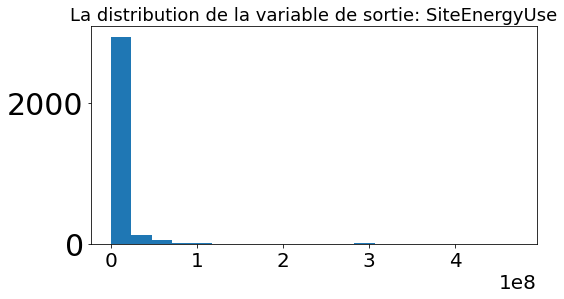

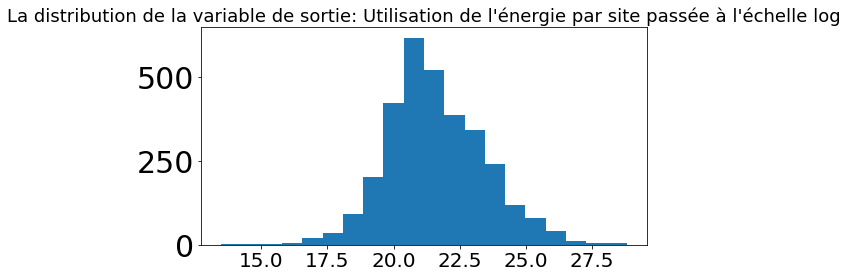

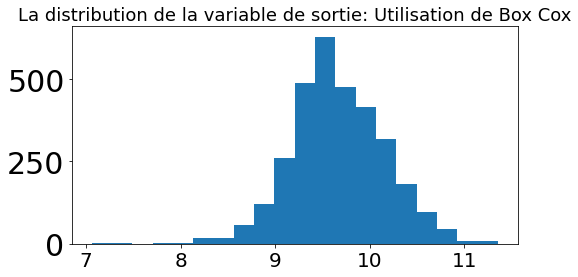

In [27]:
fig= plt.figure(figsize=(8,4))
plt.hist(data['SiteEnergyUseWN(kBtu)'] , 20)
plt.title("La distribution de la variable de sortie: SiteEnergyUse")
plt.show()

fig= plt.figure(figsize=(8,4))
data['log2_SiteEnergyUseWN(kBtu)']=np.log2(1+data['SiteEnergyUseWN(kBtu)'])
plt.hist((data['log2_SiteEnergyUseWN(kBtu)']) , 20)
plt.title("La distribution de la variable de sortie: Utilisation de l'énergie par site passée à l'échelle log")
plt.show()

data_box= data.copy()

data_box['boxcox_SiteEnergyUseWN(kBtu)'] = stats.boxcox(data_box['SiteEnergyUseWN(kBtu)'])[0]
fig= plt.figure(figsize=(8,4))
plt.hist(data_box['boxcox_SiteEnergyUseWN(kBtu)'], 20)
plt.title("La distribution de la variable de sortie: Utilisation de Box Cox")
plt.show()





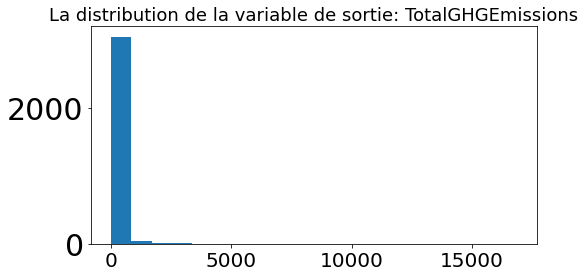

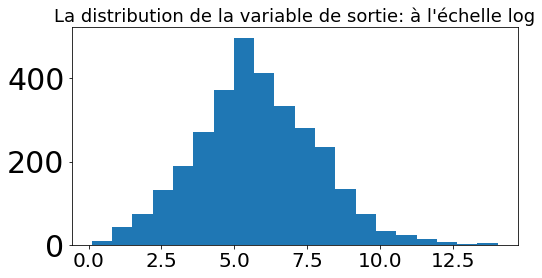

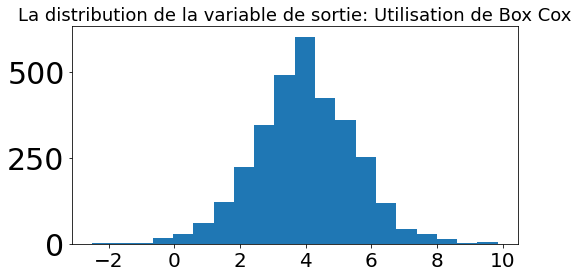

In [28]:
fig= plt.figure(figsize=(8,4))
plt.hist(data['TotalGHGEmissions'] , 20)
plt.title("La distribution de la variable de sortie: TotalGHGEmissions")
plt.show()

fig= plt.figure(figsize=(8,4))
data['log2_TotalGHGEmissions']=np.log2(1+data['TotalGHGEmissions'])
plt.hist((data['log2_TotalGHGEmissions']) , 20)
plt.title("La distribution de la variable de sortie: à l'échelle log")
plt.show()



data_box['boxcox_TotalGHGEmissions'] = stats.boxcox(data_box['TotalGHGEmissions'])[0]
fig= plt.figure(figsize=(8,4))
plt.hist(data_box['boxcox_TotalGHGEmissions'] , 20)
plt.title("La distribution de la variable de sortie: Utilisation de Box Cox")
plt.show()

In [31]:

data_model= data[['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType', 'Neighborhood',
'DefaultData',   'ComplianceStatus' ,
'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
'PropertyGFAParking', 'PropertyGFABuilding(s)','BuildingAge','log2_SiteEnergyUseWN(kBtu)', 'log2_TotalGHGEmissions']]


y_columns = ['log2_SiteEnergyUseWN(kBtu)', 'log2_TotalGHGEmissions']
X = data_model.drop(y_columns, axis=1)
numeric_columns = X.select_dtypes(['int64','float64']).columns
categoric_columns= X.select_dtypes(exclude=['int64','float64']).columns
print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape , y.shape)




(3140, 12) (3140,)
(3140, 73) (3140,)


### Régression linéaire :

In [62]:
data_comparaison= pd.DataFrame({})

In [63]:


for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {
        'normalize': [True, False]
        }
    
    lr_model = GridSearchCV(LinearRegression(), param_grid=parametres , cv=5)
    lr_model.fit(X_train, y_train)
    
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Linear Regression'],
        'coefficient de détrmination' : [r2_score(y_test, lr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(lr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, lr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, lr_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926


### Ridge 

In [64]:
for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': np.logspace(-5,5,20)}
    ridge_model = GridSearchCV(Ridge(), param_grid=parametres , cv=5)
    ridge_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Ridge'],
        'coefficient de détrmination' : [r2_score(y_test, ridge_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(ridge_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, ridge_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, ridge_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239


### Lasso  : 

In [65]:
df_comparaison= pd.DataFrame({})
for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': np.logspace(-5,1,20)}
    lasso_model = GridSearchCV(Lasso(), param_grid=parametres , cv=5)
    lasso_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Lasso'],
        'coefficient de détrmination' : [r2_score(y_test, lasso_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(lasso_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, lasso_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, lasso_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605


### ElasticNet

In [66]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                  'tol': [0.1,0.01,0.001,0.0001]
                 }
    elasticNet_model = GridSearchCV(ElasticNet(), param_grid=parametres , cv=5)
    elasticNet_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['ElasticNet'],
        'coefficient de détrmination' : [r2_score(y_test, elasticNet_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(elasticNet_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, elasticNet_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, elasticNet_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880


### Support Vector Regression : 

In [67]:
for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],#kernel coefficient [ici kernel = Radial Basis Function
                  'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
                  'C' : [0.001, 0.01, 0.1, 1, 10] #parametre de régularisation
                 }
    svr_model = GridSearchCV(SVR(), param_grid=parametres , cv=5)
    svr_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Support Vector Regression'],
        'coefficient de détrmination' : [r2_score(y_test, svr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(svr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, svr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, svr_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880
8,log2_SiteEnergyUseWN(kBtu),Support Vector Regression,0.673246,1.050735,1.104045,1.104045
9,log2_TotalGHGEmissions,Support Vector Regression,0.556716,1.355000,1.836025,1.836025


### XGB Regressor  : 

In [68]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'n_estimators' : [100,500,1000,2000]
                 }
    xgb_model = GridSearchCV(XGBRegressor(), param_grid=parametres , cv=5)
    xgb_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['XGB Regressor'],
        'coefficient de détrmination' : [r2_score(y_test, xgb_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(xgb_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, xgb_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, xgb_model.predict(X_test))]}),ignore_index=True)
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880
8,log2_SiteEnergyUseWN(kBtu),Support Vector Regression,0.673246,1.050735,1.104045,1.104045
9,log2_TotalGHGEmissions,Support Vector Regression,0.556716,1.355000,1.836025,1.836025


### Random Forest Regressor : 

In [69]:

for yi in y_columns:
    y= data_model[yi]
    X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42 )
    parametres = {'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
                  'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
                  'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
                 }
    rfr_model = GridSearchCV(RandomForestRegressor(), param_grid=parametres , cv=5)
    rfr_model.fit(X_train, y_train)
    data_comparaison= data_comparaison.append(pd.DataFrame({
        'Variable Cible':yi,
        'Modèle' : ['Random Forest Regressor'],
        'coefficient de détrmination' : [r2_score(y_test, rfr_model.predict(X_test))],
        'RMSE' : [math.sqrt(mean_squared_error(rfr_model.predict(X_test), y_test))],
        'MSE' : [metrics.mean_squared_error(y_test, rfr_model.predict(X_test))],
        'MAE' : [metrics.mean_squared_error(y_test, rfr_model.predict(X_test))]}),ignore_index=True)
data_comparaison


,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880
8,log2_SiteEnergyUseWN(kBtu),Support Vector Regression,0.673246,1.050735,1.104045,1.104045
9,log2_TotalGHGEmissions,Support Vector Regression,0.556716,1.355000,1.836025,1.836025


### GridSearch de l'ensemble des modèles aprés transformation logarithmique  : 

In [34]:
y = data_model['log2_TotalGHGEmissions']
print(X_transfrom.shape , y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y,  test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(3140, 73) (3140,)
(2512, 73) (2512,)
(628, 73) (628,)


In [35]:

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-9.074591e+20,{'normalize': False}
1,lasso,4.239548e-01,"{'alpha': 0.00018329807108324357, 'selection': 'random'}"
2,Ridge,4.240486e-01,{'alpha': 0.5455594781168515}
3,Elasticnet,4.240177e-01,"{'alpha': 0.0001, 'l1_ratio': 0.8, 'tol': 0.1}"
4,XGBRegressor,7.095348e-01,{'n_estimators': 500}
5,Random Forest Regressor,7.058417e-01,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"


In [32]:
y = data_model['log2_SiteEnergyUseWN(kBtu)']
print(X_transfrom.shape , y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y,  test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(3140, 73) (3140,)
(2512, 73) (2512,)
(628, 73) (628,)


In [33]:

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-6.410666e+20,{'normalize': False}
1,lasso,5.515492e-01,"{'alpha': 0.00018329807108324357, 'selection': 'random'}"
2,Ridge,5.509921e-01,{'alpha': 0.5455594781168515}
3,Elasticnet,5.514251e-01,"{'alpha': 0.0001, 'l1_ratio': 0.9, 'tol': 0.1}"
4,XGBRegressor,8.063267e-01,{'n_estimators': 500}
5,Random Forest Regressor,7.992095e-01,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"


### GridSearch de l'ensemble des modèles aprés transformation BoxCox  : 

In [84]:

data_model= data_box[['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType', 'Neighborhood',
'DefaultData',   'ComplianceStatus' ,
'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
'PropertyGFAParking', 'PropertyGFABuilding(s)','BuildingAge','boxcox_SiteEnergyUseWN(kBtu)', 'boxcox_TotalGHGEmissions']]


y_columns = ['boxcox_SiteEnergyUseWN(kBtu)', 'boxcox_TotalGHGEmissions']
X = data_model.drop(y_columns, axis=1)
numeric_columns = X.select_dtypes(['int64','float64']).columns
categoric_columns= X.select_dtypes(exclude=['int64','float64']).columns
print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape , y.shape)


(3140, 12) (3140,)
(3140, 73) (3140,)


In [83]:
data= data[~(data['SiteEnergyUseWN(kBtu)']==0)]
data['boxcox_SiteEnergyUseWN(kBtu)'] = stats.boxcox(data['SiteEnergyUseWN(kBtu)'])[0]
data_model= data[['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType', 'Neighborhood',
'DefaultData',   'ComplianceStatus' ,
'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
'PropertyGFAParking', 'PropertyGFABuilding(s)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'SiteEnergyUseWN(kBtu)','BuildingAge',
                 'log2_SiteEnergyUseWN(kBtu)','boxcox_SiteEnergyUseWN(kBtu)']]

data_model.drop(columns='GHGEmissionsIntensity', inplace=True)
y_columns = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)','log2_SiteEnergyUseWN(kBtu)','boxcox_SiteEnergyUseWN(kBtu)']
y= data_model['boxcox_SiteEnergyUseWN(kBtu)']
X = data_model.drop(y_columns, axis=1)

y_columns = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)','log2_SiteEnergyUseWN(kBtu)','boxcox_SiteEnergyUseWN(kBtu)']
y= data_model['boxcox_SiteEnergyUseWN(kBtu)']
X = data_model.drop(y_columns, axis=1)
num_features = X.select_dtypes(exclude=['object']).columns
categ_features = X.select_dtypes(include=['object']).columns

print(X.shape, y.shape)

names_column= []
ohe = OneHotEncoder(sparse=False)
ss = RobustScaler()
X[num_features] = ss.fit_transform(X[num_features])
ohe.fit_transform(X[categ_features])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categ_features]))
X= pd.concat([data_categ.reset_index(drop=True),X[num_features].reset_index(drop=True) ],axis=1)
print(X.shape)

(3140, 12) (3140,)
(3140, 72)


In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2512, 73) (2512,)
(628, 73) (628,)


In [59]:

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-3.407544e+12,{'normalize': False}
1,lasso,5.430147e-01,"{'alpha': 1e-05, 'selection': 'random'}"
2,Ridge,5.426806e-01,{'alpha': 0.1623776739188721}
3,Elasticnet,5.427055e-01,{'alpha': 0.0001}
4,XGBRegressor,8.048300e-01,{'n_estimators': 500}
5,decision_tree,6.919324e-01,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


A partir de la comparasion des scores obtenus par les deux types de transformation on peut conclure que la  transformation logarithmique donne des résultats plus satisfaisantes que la transformation Box Cox 

## <div class="alert alert-info"> 3. Importance des features  : </div> 

##### Pour la variable SiteEnergyUse : 

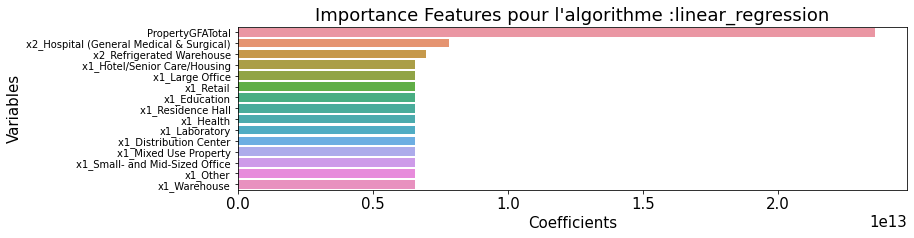

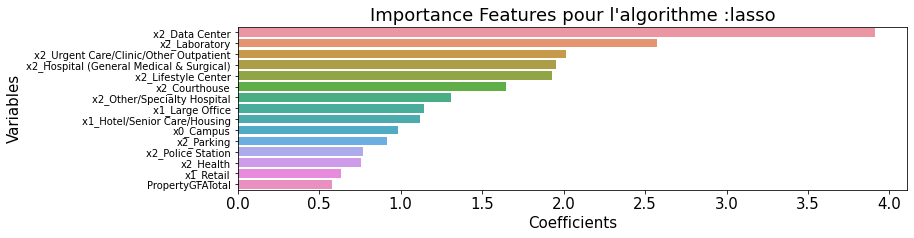

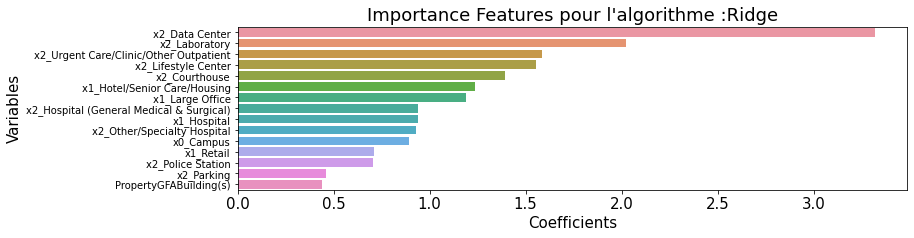

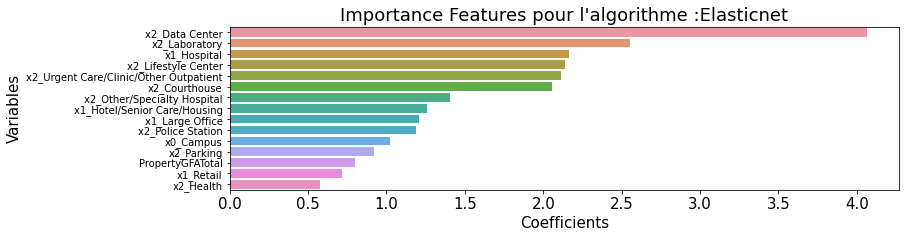

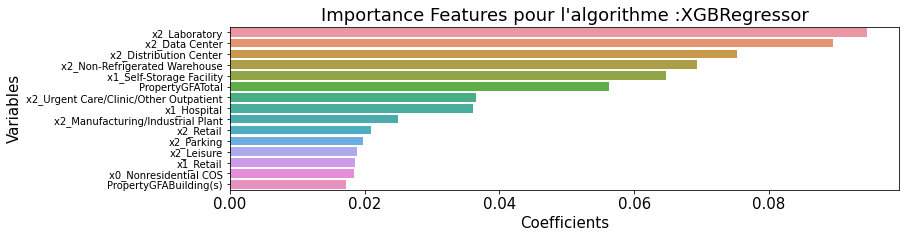

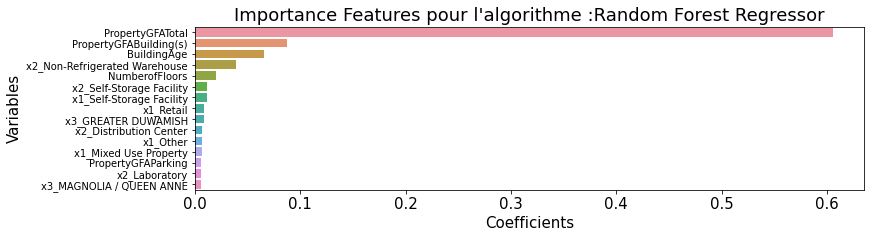

In [100]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=10) 
y = data['log2_SiteEnergyUseWN(kBtu)']
linear_model = [ 'linear_regression','lasso','Ridge','Elasticnet']
algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
for algo_name, config in algos.items():
    plt.figure(figsize = (12,3))
    df_Coefficients_Variables = pd.DataFrame({})
    gs =  GridSearchCV(config['model'], config['params'], cv=5)
    gs.fit(X_transfrom,y)
    if algo_name in linear_model: 
        coefficients= gs.best_estimator_.coef_
        
    else : 
        coefficients= gs.best_estimator_.feature_importances_
    df_Coefficients_Variables= pd.concat([pd.DataFrame(data=X_transfrom.columns , columns=['Variables']), pd.DataFrame(data=coefficients, columns=['Coefficients'])], axis=1).sort_values(by='Coefficients', ascending=False).head(15)
    sns.barplot(x=df_Coefficients_Variables['Coefficients'], y=df_Coefficients_Variables['Variables'])
    title= "Importance Features pour l'algorithme :" +algo_name
    plt.title(title)
    plt.show()
        
        


##### Pour la variable TotalGHGEmissions : 

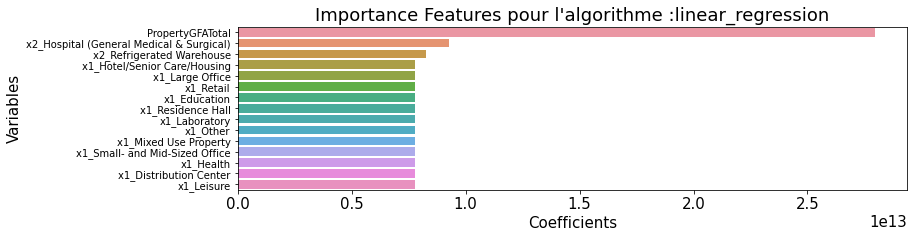

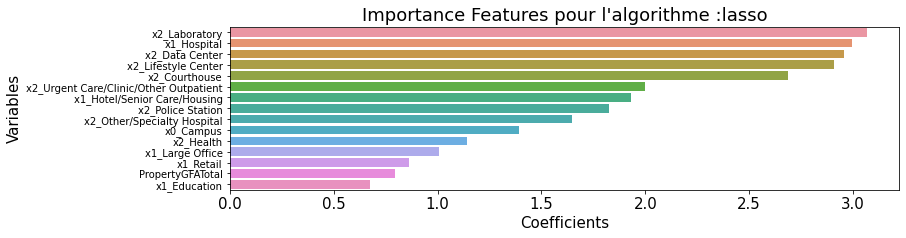

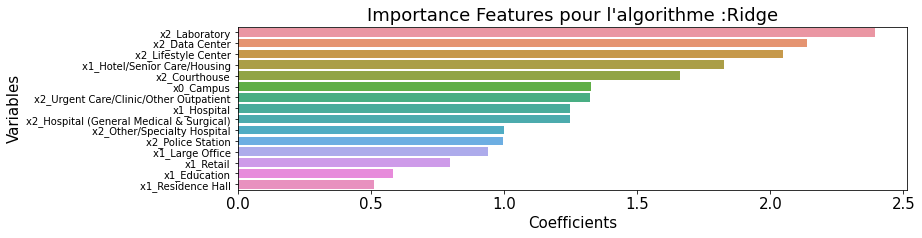

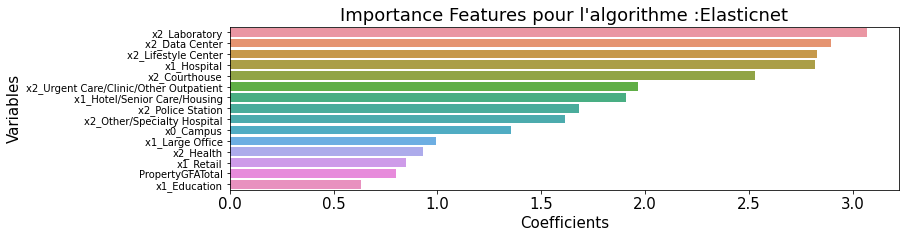

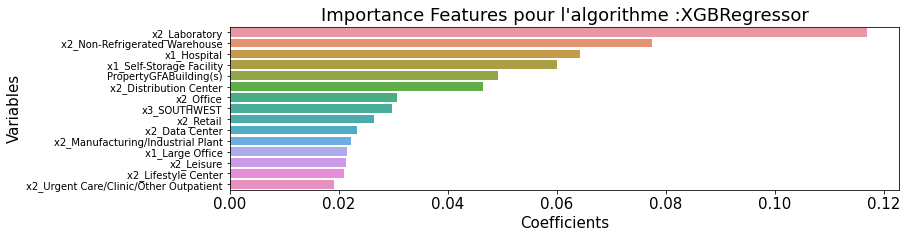

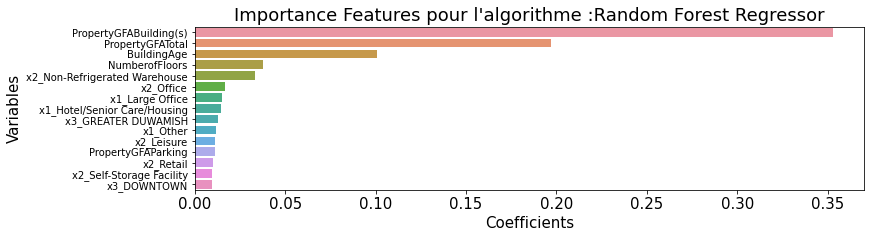

In [101]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=10) 
y = data['log2_TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y,  test_size = 0.2, random_state = 42)


linear_model = [ 'linear_regression','lasso','Ridge','Elasticnet']
algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
for algo_name, config in algos.items():
    plt.figure(figsize = (12,3))
    df_Coefficients_Variables = pd.DataFrame({})
    gs =  GridSearchCV(config['model'], config['params'], cv=5)
    gs.fit(X_transfrom,y)
    if algo_name in linear_model: 
        coefficients= gs.best_estimator_.coef_
        
    else : 
        coefficients= gs.best_estimator_.feature_importances_
    df_Coefficients_Variables= pd.concat([pd.DataFrame(data=X_transfrom.columns , columns=['Variables']), pd.DataFrame(data=coefficients, columns=['Coefficients'])], axis=1).sort_values(by='Coefficients', ascending=False).head(15)
    sns.barplot(x=df_Coefficients_Variables['Coefficients'], y=df_Coefficients_Variables['Variables'])
    title= "Importance Features pour l'algorithme :" +algo_name
    plt.title(title)
    plt.show()
        
        


## <div class="alert alert-info"> 4. Comparaison des modèles : </div> 

In [99]:
data_comparaison

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880
8,log2_SiteEnergyUseWN(kBtu),Support Vector Regression,0.673246,1.050735,1.104045,1.104045
9,log2_TotalGHGEmissions,Support Vector Regression,0.556716,1.355000,1.836025,1.836025


In [100]:
data_comparaison_Energy= data_comparaison[data_comparaison['Variable Cible']=='log2_SiteEnergyUseWN(kBtu)']
data_comparaison_Energy

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
0,log2_SiteEnergyUseWN(kBtu),Linear Regression,0.525946,1.265601,1.601745,1.601745
2,log2_SiteEnergyUseWN(kBtu),Ridge,0.526438,1.264943,1.600081,1.600081
4,log2_SiteEnergyUseWN(kBtu),Lasso,0.526843,1.264402,1.598712,1.598712
6,log2_SiteEnergyUseWN(kBtu),ElasticNet,0.526448,1.264930,1.600049,1.600049
8,log2_SiteEnergyUseWN(kBtu),Support Vector Regression,0.673246,1.050735,1.104045,1.104045
10,log2_SiteEnergyUseWN(kBtu),XGB Regressor,0.820310,0.779191,0.607139,0.607139
12,log2_SiteEnergyUseWN(kBtu),Random Forest Regressor,0.815452,0.789654,0.623554,0.623554


In [101]:
data_comparaison_Emission= data_comparaison[data_comparaison['Variable Cible']=='log2_TotalGHGEmissions']
data_comparaison_Emission

,Variable Cible,Modèle,coefficient de détrmination,RMSE,MSE,MAE
1,log2_TotalGHGEmissions,Linear Regression,0.401255,1.574778,2.479926,2.479926
3,log2_TotalGHGEmissions,Ridge,0.402628,1.572971,2.474239,2.474239
5,log2_TotalGHGEmissions,Lasso,0.402057,1.573723,2.476605,2.476605
7,log2_TotalGHGEmissions,ElasticNet,0.401991,1.573811,2.476880,2.476880
9,log2_TotalGHGEmissions,Support Vector Regression,0.556716,1.355000,1.836025,1.836025
11,log2_TotalGHGEmissions,XGB Regressor,0.790249,0.932074,0.868763,0.868763
13,log2_TotalGHGEmissions,Random Forest Regressor,0.767766,0.980758,0.961886,0.961886


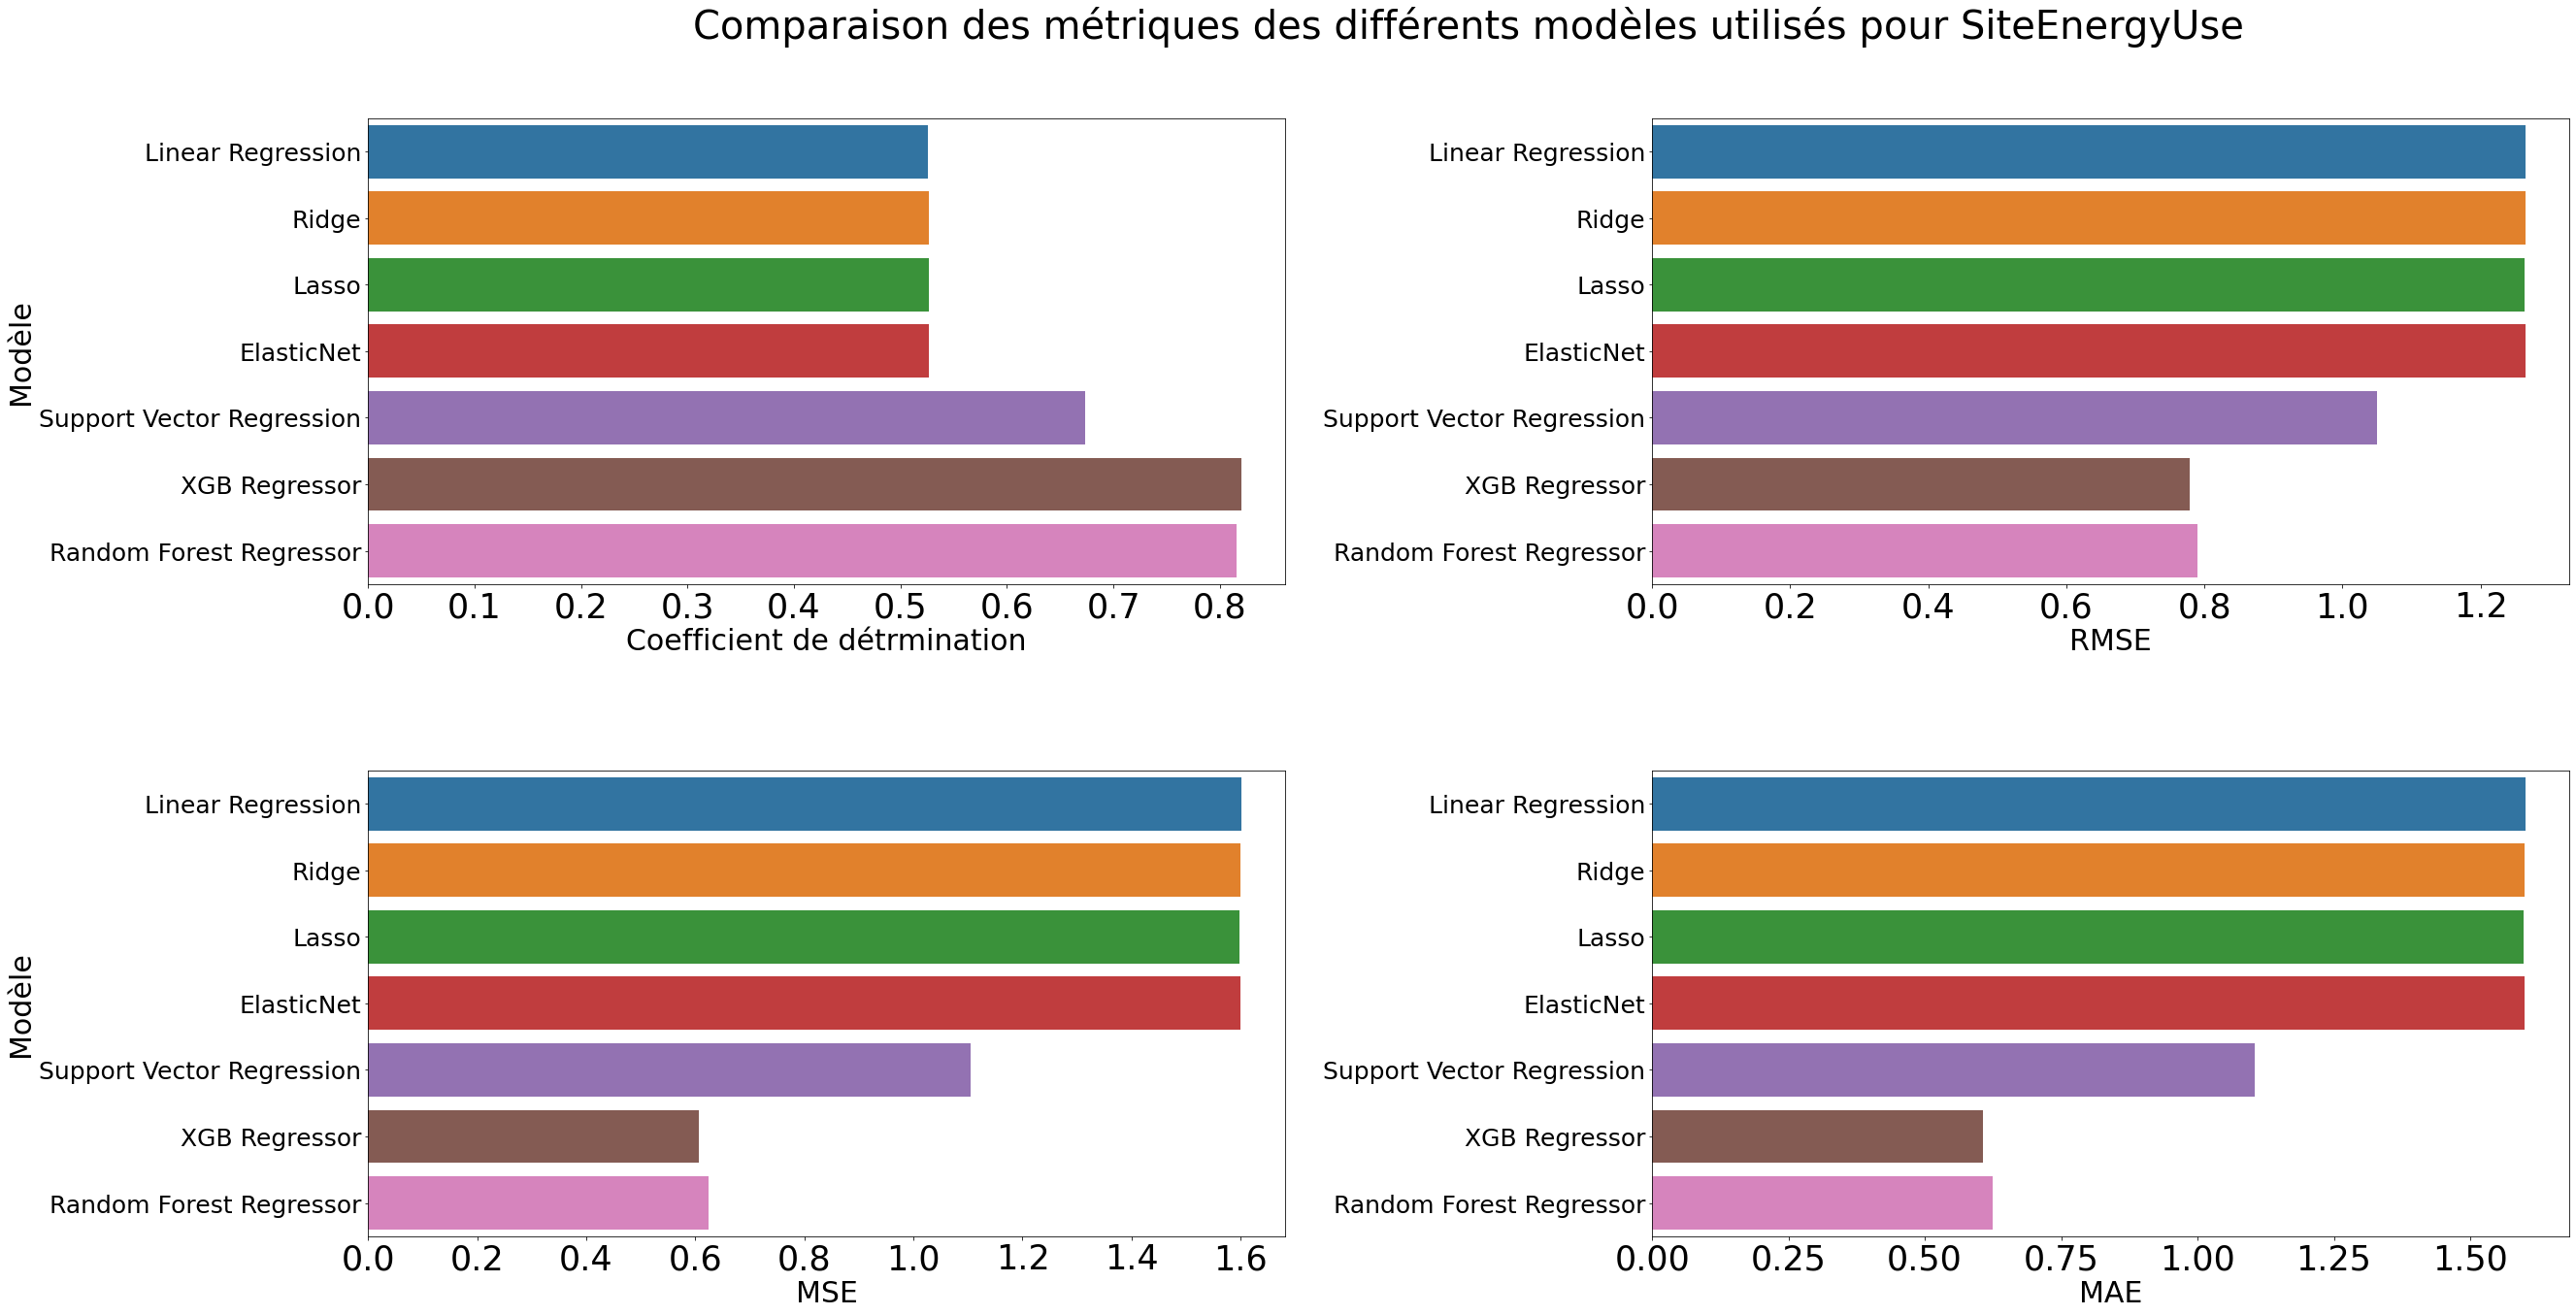

In [111]:
plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=25) 
fig,ax=plt.subplots(2,2, figsize=(35,20))
fig.suptitle("Comparaison des métriques des différents modèles utilisés pour SiteEnergyUse" , fontsize=40)


ax[0][0]= sns.barplot(x=data_comparaison_Energy['coefficient de détrmination'], y= data_comparaison_Energy['Modèle'], ax= ax[0][0])
ax[0][0].set_xlabel('Coefficient de détrmination', fontsize=30)
ax[0][0].set_ylabel('Modèle' , fontsize=30)

ax[0][1]= sns.barplot(x=data_comparaison_Energy['RMSE'], y= data_comparaison_Energy['Modèle'], ax= ax[0][1])
ax[0][1].set_ylabel(' ')
ax[0][1].set_xlabel('RMSE', fontsize=30)

ax[1][0]= sns.barplot(x=data_comparaison_Energy['MSE'], y= data_comparaison_Energy['Modèle'], ax= ax[1][0])
ax[1][0].set_xlabel('MSE', fontsize=30)
ax[1][0].set_ylabel('Modèle' , fontsize=30)


ax[1][1]= sns.barplot(x=data_comparaison_Energy['MAE'], y= data_comparaison_Energy['Modèle'], ax= ax[1][1])
ax[1][1].set_xlabel('MAE', fontsize=30)
ax[1][1].set_ylabel(' ')



plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

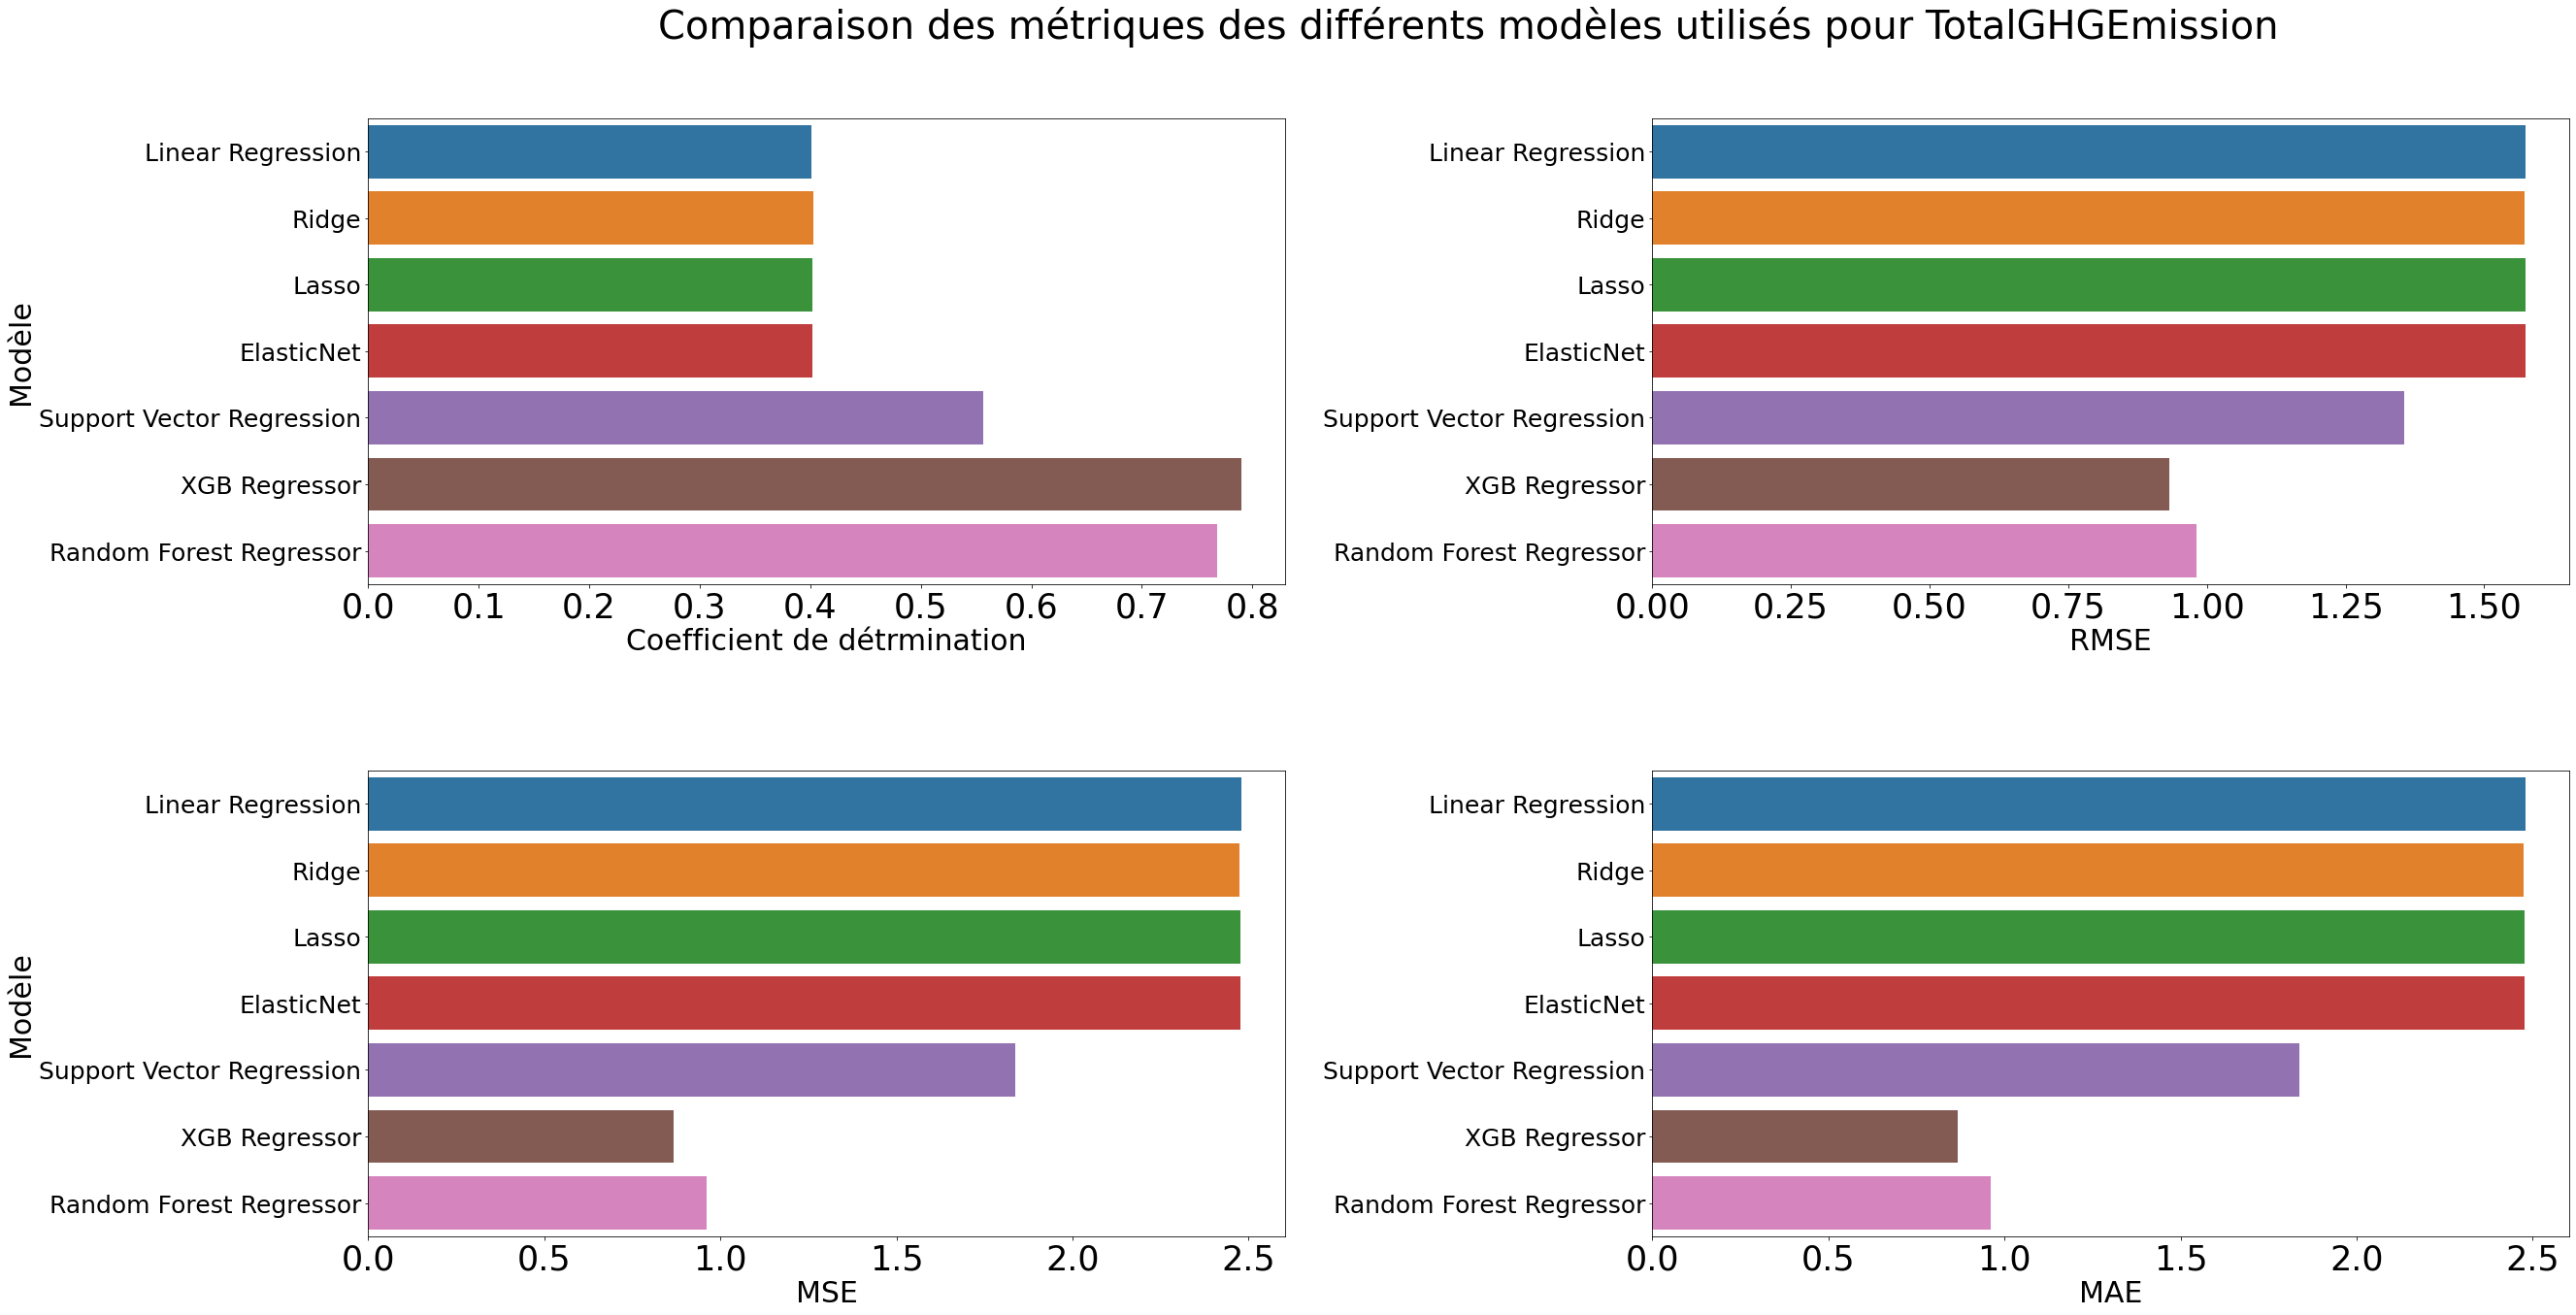

In [109]:
plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=25) 
fig,ax=plt.subplots(2,2, figsize=(35,20))
fig.suptitle("Comparaison des métriques des différents modèles utilisés pour TotalGHGEmission" , fontsize=40)


ax[0][0]= sns.barplot(x=data_comparaison_Emission['coefficient de détrmination'], y= data_comparaison_Emission['Modèle'], ax= ax[0][0])
ax[0][0].set_xlabel('Coefficient de détrmination', fontsize=30)
ax[0][0].set_ylabel('Modèle' , fontsize=30)

ax[0][1]= sns.barplot(x=data_comparaison_Emission['RMSE'], y= data_comparaison_Emission['Modèle'], ax= ax[0][1])
ax[0][1].set_ylabel(' ')
ax[0][1].set_xlabel('RMSE', fontsize=30)

ax[1][0]= sns.barplot(x=data_comparaison_Emission['MSE'], y= data_comparaison_Emission['Modèle'], ax= ax[1][0])
ax[1][0].set_xlabel('MSE', fontsize=30)
ax[1][0].set_ylabel('Modèle' , fontsize=30)


ax[1][1]= sns.barplot(x=data_comparaison_Emission['MAE'], y= data_comparaison_Emission['Modèle'], ax= ax[1][1])
ax[1][1].set_xlabel('MAE', fontsize=30)
ax[1][1].set_ylabel(' ')



plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.4, hspace=0.4)

plt.show()


## <div class="alert alert-info"> 5. Evaluation de l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions:</div> 

In [38]:
dataEnergy = pd.read_csv('dataEnergyScore.csv')

In [45]:
dataEnergy['log2_TotalGHGEmissions']=np.log2(1+dataEnergy['TotalGHGEmissions'])
data_model= dataEnergy[['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType', 'Neighborhood',
'DefaultData',   'ComplianceStatus' ,'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore',
'PropertyGFAParking', 'PropertyGFABuilding(s)','BuildingAge','log2_TotalGHGEmissions']]

y= data_model['log2_TotalGHGEmissions']
X = data_model.drop(columns='log2_TotalGHGEmissions', axis=1)
numeric_columns = X.select_dtypes(['int64','float64']).columns
categoric_columns= X.select_dtypes(exclude=['int64','float64']).columns
print(numeric_columns)
print(categoric_columns)
print(X.shape, y.shape)


names_column= []
ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numeric_columns] = ss.fit_transform(X[numeric_columns])
ohe.fit_transform(X[categoric_columns])
names= ohe.get_feature_names().tolist()
for i in names : 
    names_column.append(i)
data_categ = pd.DataFrame(columns=names_column, data= ohe.fit_transform(X[categoric_columns]))
X_transfrom= pd.concat([data_categ.reset_index(drop=True),X[numeric_columns].reset_index(drop=True) ],axis=1)
print(X_transfrom.shape , y.shape)



X_train, X_test, y_train, y_test = train_test_split(X_transfrom, y,  test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ENERGYSTARScore', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'BuildingAge'],
      dtype='object')
Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'Neighborhood', 'DefaultData', 'ComplianceStatus'],
      dtype='object')
(2115, 13) (2115,)
(2115, 62) (2115,)
(1692, 62) (1692,)
(423, 62) (423,)


In [46]:

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,500,1000,2000]
            }},
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,-7.087228e+22,{'normalize': False}
1,lasso,5.261095e-01,"{'alpha': 0.0007847599703514606, 'selection': 'cyclic'}"
2,Ridge,5.253796e-01,{'alpha': 0.5455594781168515}
3,Elasticnet,5.262648e-01,"{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.01}"
4,XGBRegressor,7.558192e-01,{'n_estimators': 2000}
5,Random Forest Regressor,7.559343e-01,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}"
